In [1]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from cache_decorator import Cache
from tqdm.keras import TqdmCallback
from barplots import barplots

## Data retrieval
First, we retrieve the data and impute and scale them.

In [2]:
# Retrieving the data
X, y = load_epigenomes(
    cell_line = "K562",
    dataset = "fantom",
    region = "enhancers",
    window_size = 256,
    root = "datasets" # Path where to download data
)

# Creating the imputer
imputer = KNNImputer()
# Creating the scaler
scaler = RobustScaler()

# Imputing and scaling the data
X = pd.DataFrame(
    scaler.fit_transform(
        imputer.fit_transform(X)
    ),
    index=X.index,
    columns=X.columns
)

## Feature selection
We will execute a feature selection step in each one of the holdouts, using the training data of the holdout. Otherwise, if we were to use all data, we would induce a possible positive bias in the model performance since we would use also data that we reserve to evaluate the models performance.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from multiprocessing import cpu_count

@Cache(
    cache_path=[
        "active_enhancers_performance/{function_name}/kept_features_{_hash}.json",
        "active_enhancers_performance/{function_name}/discarded_features_{_hash}.json"
    ],
    args_to_ignore=[
        "X_train", "y_train"
    ]
)
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    max_iter: int = 100
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5),
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=False,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

## Model evaluation
In order to evaluate the model, we create a generator of **stratified** holdouts.

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

number_of_splits = 10

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

### Evaluation of the models predictions
In order to evaluate the models predictions, we consider the Accuracy, AUPRC and AUROC metrics:

In [5]:
from typing import Dict
from sanitize_ml_labels import sanitize_ml_labels
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score


def evaluate_model_prediction(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Return the evaluation of the given predictions.
    
    Parameters
    ---------------------
    y_true: np.ndarray,
        The ground truth labels.
    y_pred: np.ndarray,
        The predicted labels.
    
    Raises
    ---------------------
    ValueError,
        If the two given numpy arrays do not have the same shape.
    
    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    if y_true.shape != y_pred.shape:
        raise ValueError(
            "The two arrays do not have the same shape: {} != {}".format(
                y_true.shape, y_pred.shape
            )
        )
    float_metrics = average_precision_score, roc_auc_score
    int_metrics = (accuracy_score, )
    return {
        ** {
            sanitize_ml_labels(metric.__name__): metric(y_true, y_pred)
            for metric in float_metrics
        },
        ** {
            sanitize_ml_labels(metric.__name__): metric(y_true, np.round(y_pred).astype(int))
            for metric in int_metrics
        }
    }

In [6]:
def evaluate_all_model_prediction(
    y_train_true: np.ndarray,
    y_train_pred: np.ndarray,
    y_test_true: np.ndarray,
    y_test_pred: np.ndarray,
    model_name: str,
    holdout_number: int,
    use_feature_selection: bool,
) -> Dict[str, float]:
    """Return the evaluation of the given predictions.
    
    Parameters
    ---------------------
    y_train_true: np.ndarray,
        Ground truth labels used during training.
    y_train_pred: np.ndarray,
        Training predictions
    y_test_true: np.ndarray,
        Ground truth labels used for test.
    y_test_pred: np.ndarray,
        Test predictions
    model_name: str,
        Name of the model used.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features that have
        been selected with Boruta or not.
    
    Returns
    ---------------------
    Dictionary with the performance metrics
    """
    common_informations = {
        "model_name": model_name,
        "holdout_number": holdout_number,
        "use_feature_selection": use_feature_selection
    }
    return [
        {
            **evaluate_model_prediction(y_train_true, y_train_pred),
            "run_type": "train",
            **common_informations
        },
        {
            **evaluate_model_prediction(y_test_true, y_test_pred),
            "run_type": "test",
            **common_informations
        },
    ]

### Decision Tree
We define a method to create and train a Decision Tree model:

In [7]:
from sklearn.tree import DecisionTreeClassifier


@Cache(
    cache_path="active_enhancers_performance/{function_name}/{_hash}.json",
    args_to_ignore=[
        "X_train", "X_test", "y_train", "y_test"
    ]
)
def train_decision_tree(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    holdout_number: int,
    use_feature_selection: bool
) -> Dict[str, float]:
    """Return performance of a Decision Tree model.
    
    Parameters
    ----------------------
    X_train: np.ndarray,
        Data reserved for the input during training of the model.
    X_test: np.ndarray,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features that have
        been selected with Boruta or not.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    tree = DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=100
    )
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    return evaluate_all_model_prediction(
        y_train, y_train_pred, y_test, y_test_pred,
        "Decision Tree", holdout_number, use_feature_selection
    )

### Random Forest
We define a method to create and train a Random Forest model:

In [8]:
from sklearn.ensemble import RandomForestClassifier
from multiprocessing import cpu_count


@Cache(
    cache_path="active_enhancers_performance/{function_name}/{_hash}.json",
    args_to_ignore=[
        "X_train", "X_test", "y_train", "y_test"
    ]
)
def train_random_forest(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    holdout_number: int,
    use_feature_selection: bool
) -> Dict[str, float]:
    """Return performance of a Random Forest model.
    
    Parameters
    ----------------------
    X_train: np.ndarray,
        Data reserved for the input during training of the model.
    X_test: np.ndarray,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features that have
        been selected with Boruta or not.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    forest = RandomForestClassifier(
        n_estimators=600,
        class_weight="balanced_subsample",
        max_depth=5,
        min_samples_leaf=100,
        n_jobs=cpu_count(),
        verbose=False
    )
    forest.fit(X_train, y_train)
    y_train_pred = forest.predict(X_train)
    y_test_pred = forest.predict(X_test)
    return evaluate_all_model_prediction(
        y_train, y_train_pred, y_test, y_test_pred,
        "Random Forest", holdout_number, use_feature_selection
    )

### Perceptron
We define a method to create and train a Perceptron model:

In [9]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from extra_keras_metrics import get_standard_binary_metrics


@Cache(
    cache_path="active_enhancers_performance/{function_name}/{_hash}.json",
    args_to_ignore=[
        "X_train", "X_test", "y_train", "y_test"
    ]
)
def train_perceptron(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    holdout_number: int,
    use_feature_selection: bool
) -> Dict[str, float]:
    """Return performance of a Perceptron.
    
    Parameters
    ----------------------
    X_train: np.ndarray,
        Data reserved for the input during training of the model.
    X_test: np.ndarray,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features that have
        been selected with Boruta or not.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    perceptron = Sequential([
        Input((X_train.shape[1], )),
        Dense(1, activation="sigmoid")
    ])
    perceptron.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=get_standard_binary_metrics()
    )
    perceptron.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=1000,
        batch_size=1024,
        verbose=False,
        callbacks=[
            EarlyStopping("loss"),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            #TqdmCallback(verbose=1)
        ]
    )
    y_train_pred = perceptron.predict(X_train)
    y_test_pred = perceptron.predict(X_test)
    return evaluate_all_model_prediction(
        y_train, y_train_pred, y_test, y_test_pred,
        "Perceptron", holdout_number, use_feature_selection
    )

### FFNN
We define a method to create and train a FFNN model:

In [10]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from extra_keras_metrics import get_standard_binary_metrics


@Cache(
    cache_path="active_enhancers_performance/{function_name}/{_hash}.json",
    args_to_ignore=[
        "X_train", "X_test", "y_train", "y_test"
    ]
)
def train_ffnn(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    holdout_number: int,
    use_feature_selection: bool
) -> Dict[str, float]:
    """Return performance of a FFNN.
    
    Parameters
    ----------------------
    X_train: np.ndarray,
        Data reserved for the input during training of the model.
    X_test: np.ndarray,
        Data reserved for the input during  test of the model.
    y_train: np.ndarray,
        Data reserved for the output during  training of the model.
    y_test: np.ndarray,
        Data reserved for the output during  test of the model.
    holdout_number: int,
        Number of the holdout.
    use_feature_selection: bool,
        Whether the model is trained using features that have
        been selected with Boruta or not.
        
    Returns
    ----------------------
    Dictionary with the model perfomance.
    """
    ffnn = Sequential([
        Input((X_train.shape[1], )),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    ffnn.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=get_standard_binary_metrics()
    )
    ffnn.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=1000,
        batch_size=1024,
        verbose=False,
        callbacks=[
            EarlyStopping("loss"),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            # TqdmCallback(verbose=1)
        ]
    )
    y_train_pred = ffnn.predict(X_train)
    y_test_pred = ffnn.predict(X_test)
    return evaluate_all_model_prediction(
        y_train, y_train_pred, y_test, y_test_pred,
        "FFNN", holdout_number, use_feature_selection
    )

### Finally we create the main loop!
Now we can put everything togheter and run our experiment!

In [11]:
# Create a list to store all the computed performance
all_performance = []

# Start the main loop, iterating through the holdouts
for holdout_number, (train_indices, test_indices) in tqdm(
    enumerate(holdouts_generator.split(X, y)),
    total=number_of_splits,
    desc="Computing holdouts"
):
    # We do an internal loop for whether to use feature selection or not
    # Generally speaking, we always want to know if feature selection is doing something or not.
    for use_feature_selection in tqdm((True, False), desc="Running feature selection", leave=False):
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        # If the flag for feature selection is set, we compute the features
        # To keep and discard using Boruta.
        # We only do the feature selection once per holdout
        # because the data remains constant within the holdout.
        if use_feature_selection:
            kept_features, discarded_features = execute_boruta_feature_selection(
                X_train,
                y_train.values.ravel(),
                holdout_number
            )
            # We filter the DataFrames columns using the features that
            # Boruta has decided we should keep
            X_train = X_train[kept_features]
            X_test = X_test[kept_features]
        # We train the models we have prepared, that is:
        # - A Decision Tree
        # - A Random Forest
        # - A Perceptron
        # - A Feed-Forward Neural-Network (FFNN)
        for train_model in tqdm(
            (train_decision_tree, train_random_forest, train_perceptron, train_ffnn),
            desc="Training models",
            leave=False
        ):
            # We compute the model performance
            performance = train_model(
                X_train.values, X_test.values, y_train.values, y_test.values,
                holdout_number,
                use_feature_selection
            )
            # We chain the computed performance to the performance list
            all_performance += performance
    
# We convert the computed performance list into a DataFrame
all_performance = pd.DataFrame(all_performance)

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Running feature selection:   0%|          | 0/2 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

Training models:   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
all_performance

,AUPRC,AUROC,Accuracy,run_type,model_name,holdout_number,use_feature_selection
0,0.127765,0.530922,0.916114,train,Decision Tree,0,True
1,0.114030,0.525977,0.913803,test,Decision Tree,0,True
2,0.179143,0.729564,0.757012,train,Random Forest,0,True
3,0.170895,0.716735,0.751837,test,Random Forest,0,True
4,0.312279,0.764377,0.915521,train,Perceptron,0,True
...,...,...,...,...,...,...,...
155,0.181355,0.733804,0.756103,test,Random Forest,9,False
156,0.329452,0.775812,0.916193,train,Perceptron,9,False
157,0.317872,0.781855,0.915067,test,Perceptron,9,False
158,0.634358,0.905596,0.937090,train,FFNN,9,False


### Results visualization
Now that we have run our experiment we can visualize its performance:

In [13]:
# Slightly adapting the dataframe in order to visualiza it better
all_performance["use_feature_selection"] = [
    "Feature Selection" if use_selection else "No feature selection"
    for use_selection in all_performance["use_feature_selection"]
]
all_performance = all_performance.drop(columns=["holdout_number"])

Rendering barplots:   0%|          | 0/3 [00:00<?, ?it/s]

((<Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>,
  <Figure size 1600x1560 with 1 Axes>),
 (array([<AxesSubplot:title={'center':'Accuracy'}, xlabel='Accuracy'>],
        dtype=object),
  array([<AxesSubplot:title={'center':'AUPRC'}, xlabel='AUPRC'>],
        dtype=object),
  array([<AxesSubplot:title={'center':'AUROC'}, xlabel='AUROC'>],
        dtype=object)))

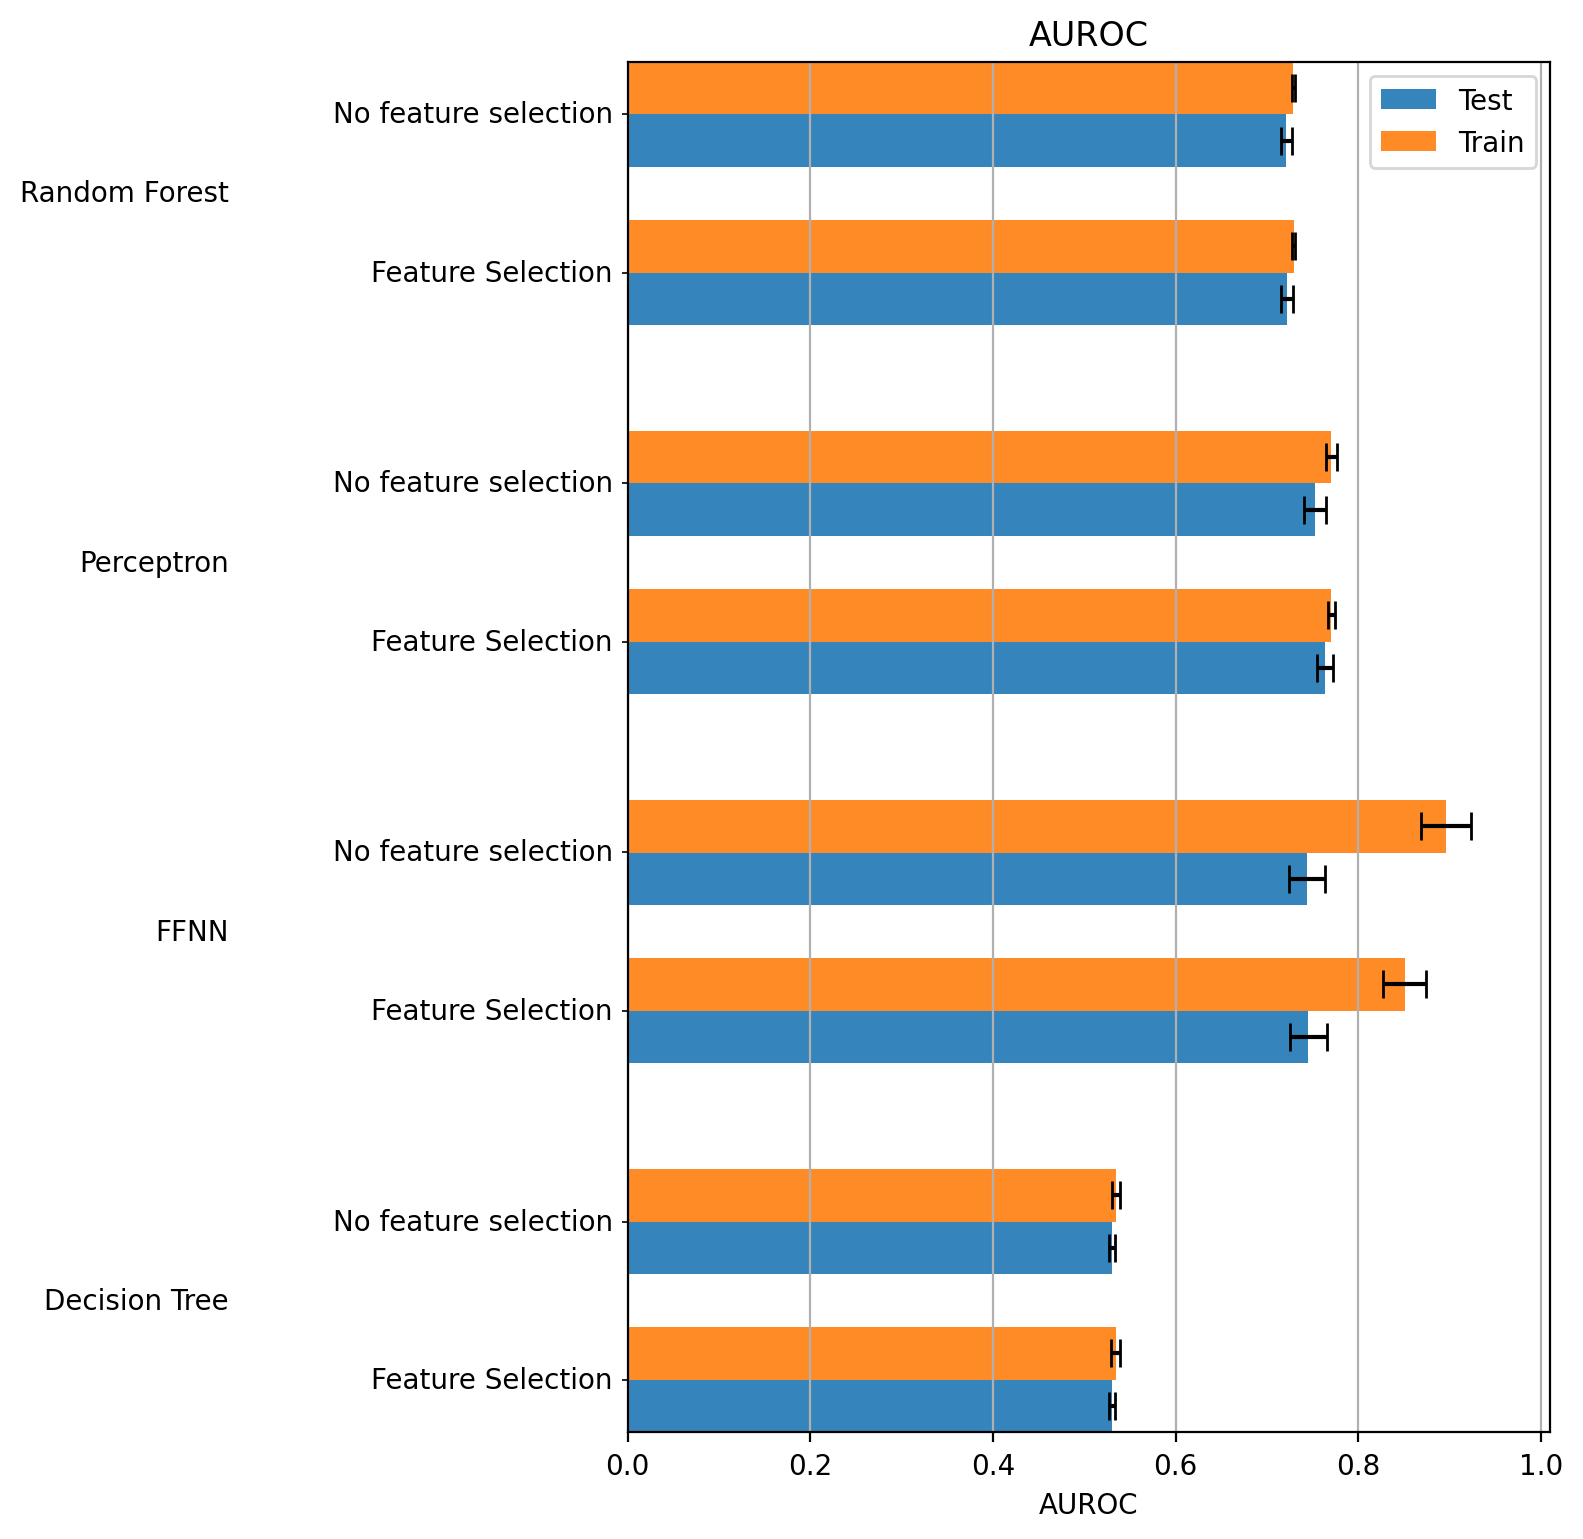

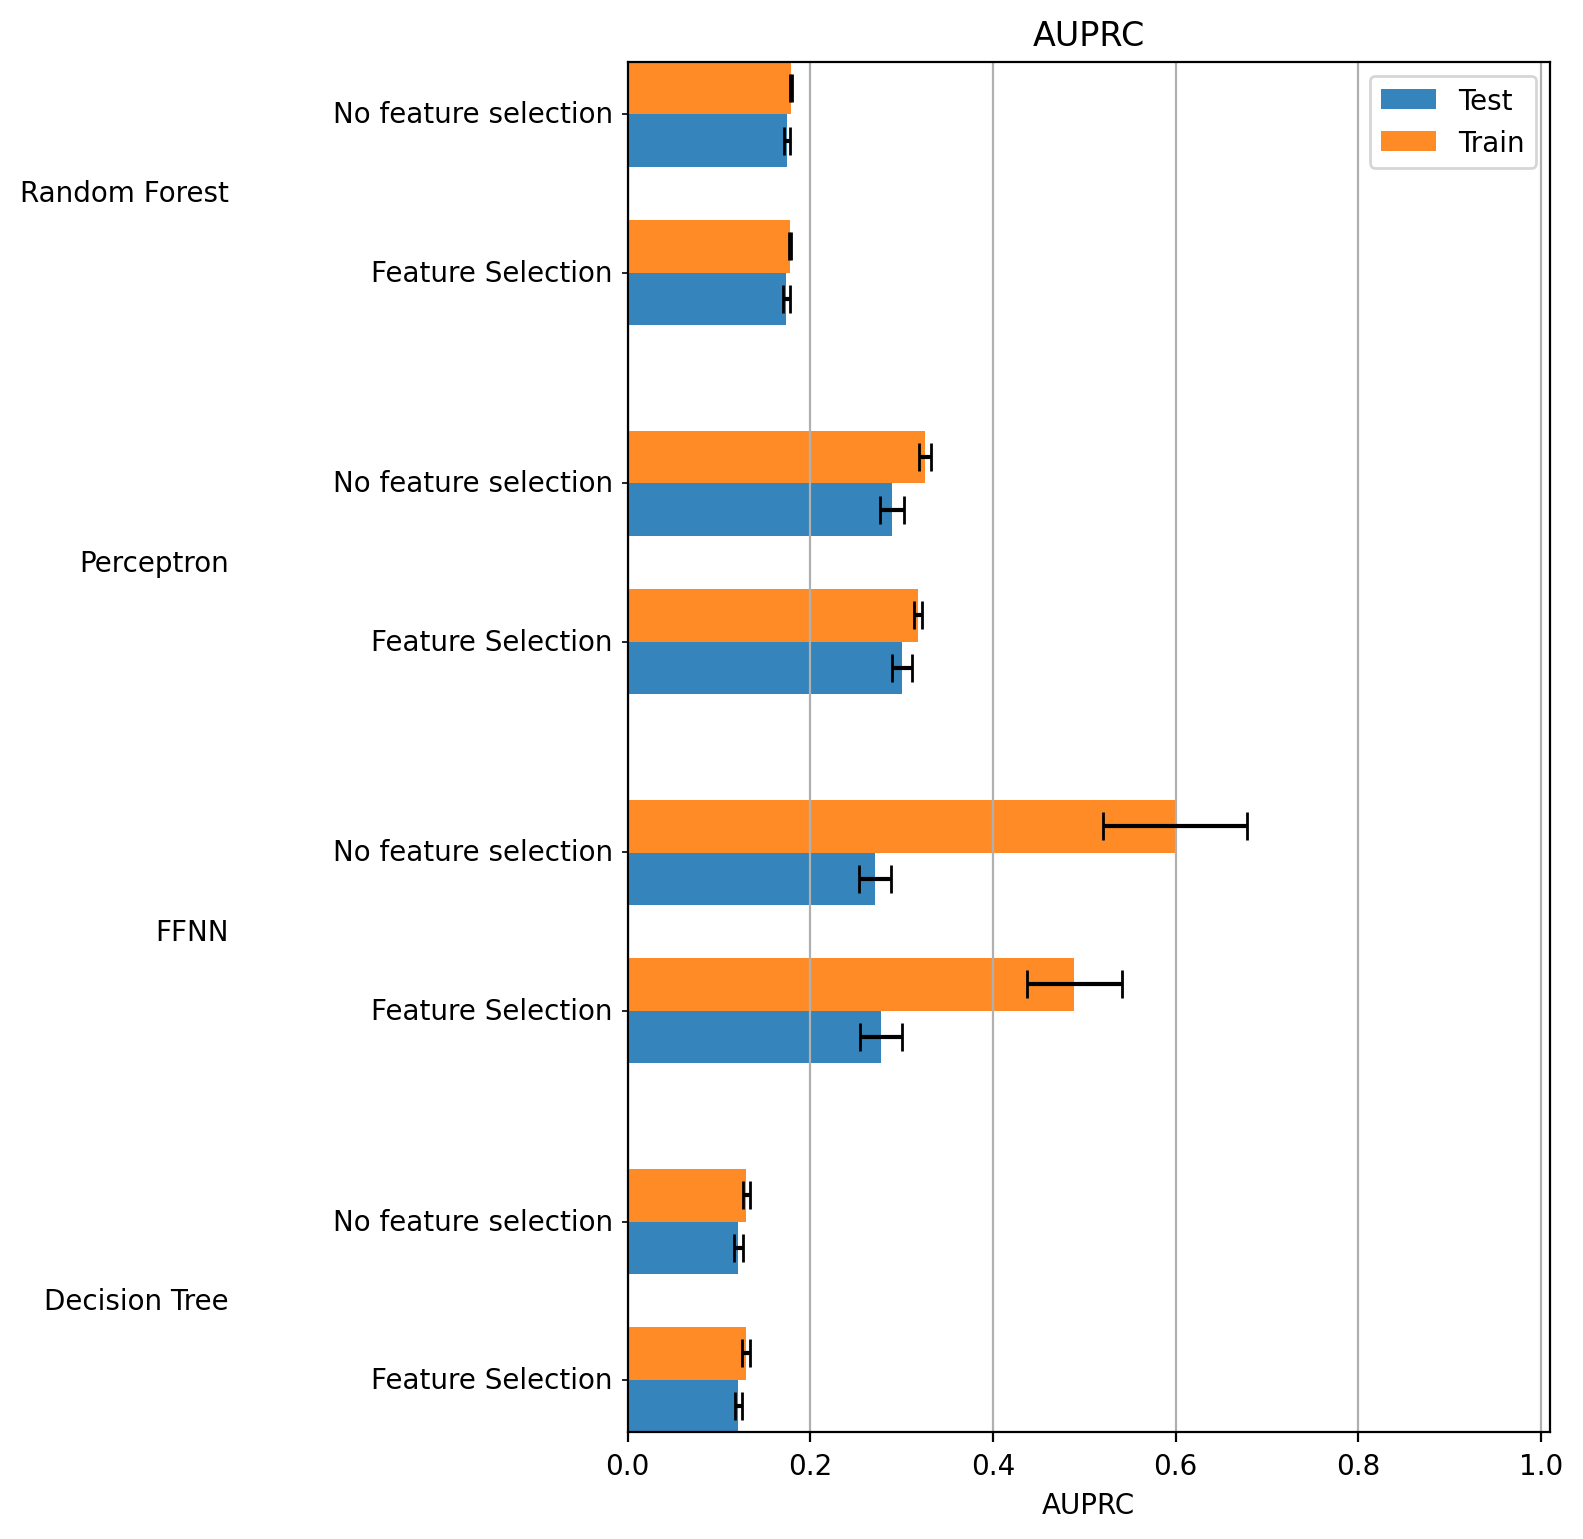

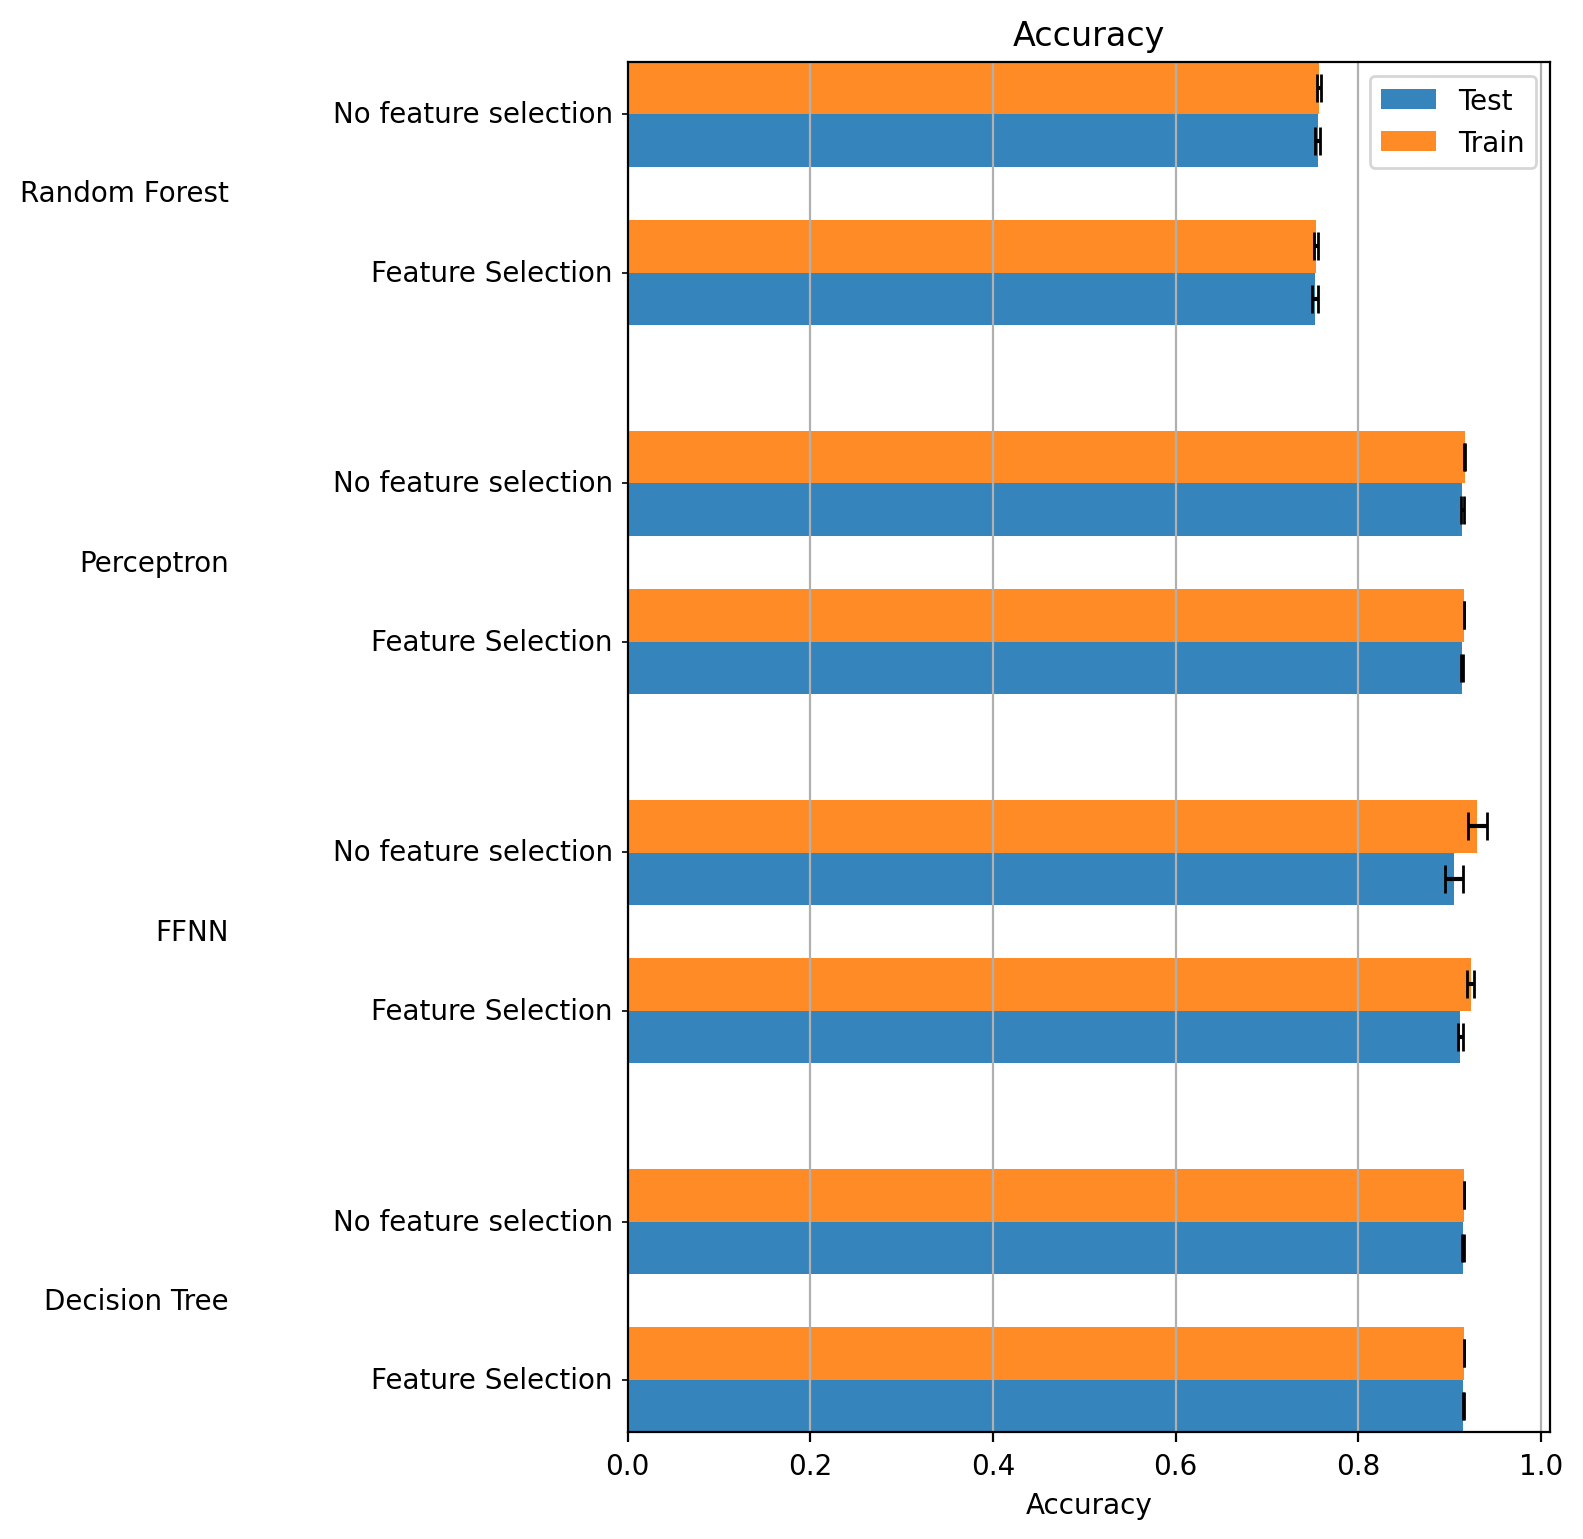

In [14]:
barplots(
    all_performance,
    groupby=["model_name", "use_feature_selection", "run_type"],
    orientation="horizontal",
    height=8
)